# Downstream: DGEA and GSEA

Differential gene expression (DGE) analysis is a crucial tool for identifying genes that are significantly over- or underexpressed between different conditions (e.g., healthy vs. disease) within specific cell types. While many tools exist for DGE analysis, recent studies suggest that pseudobulk methods (which aggregate cell-type-specific expression values per individual) perform particularly well for single-cell data, helping to avoid issues like pseudoreplication and inflated false discovery rates. In this tutorial, we'll show how to perform both, primarily using the packages `decoupleR` and `pybiomart` for gene symbol conversion. If you haven't yet installed it, you can do so with

```
pip install decoupler pybiomart
```

In [73]:
import scanpy as sc
import pandas as pd
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt

# for differential expression analysis
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import adjustText

sc.settings.njobs = 1

## Understanding Pseudobulk Analysis

When working with single-cell data across multiple conditions, performing differential expression at the single-cell level can lead to inflated p-values because each cell is treated as an independent sample. However, cells from the same sample are not truly independent since they share the same environment. Additionally, uneven cell numbers between samples can bias results.

The pseudobulk approach addresses these issues by:
1. Aggregating cells from the same sample and cell type
2. Working with raw counts rather than normalized data
3. Requiring multiple biological replicates per condition
4. Accounting for sample-level variation

## Generate Pseudobulks

We'll now create pseudobulk profiles by summing counts across cells from the same sample and cell type. This helps recover lowly expressed genes that might be affected by dropout in single-cell analysis and provides a more robust foundation for differential expression testing.

In [2]:
adata_raw = sc.datasets.ebi_expression_atlas("E-MTAB-9221", filter_boring=True)

# Rename meta-data
columns = [
    "Sample Characteristic[sex]",
    "Sample Characteristic[individual]",
    "Sample Characteristic[disease]",
    "Factor Value[inferred cell type - ontology labels]",
]
adata_raw.obs = adata_raw.obs[columns]
adata_raw.obs.columns = ["sex", "individual", "disease", "cell_type"]
adata_raw

adata_raw

AnnData object with n_obs × n_vars = 6807 × 20522
    obs: 'sex', 'individual', 'disease', 'cell_type'

In [101]:
adata_raw.to_df().head()

ENSG00000000003  ENSG00000000419  \
SAMEA6979313-AAACCCAAGACTCAAA              0.0         0.000000   
SAMEA6979313-AAAGAACCACCTGCTT              0.0         0.000000   
SAMEA6979313-AAAGGATGTCCCTCAT              0.0         1.082781   
SAMEA6979313-AAAGGGTGTCCCTCAT              0.0         0.000000   
SAMEA6979313-AAAGGTTGTCCCTCAT              0.0         0.000000   

                               ENSG00000000457  ENSG00000000460  \
SAMEA6979313-AAACCCAAGACTCAAA              0.0              0.0   
SAMEA6979313-AAAGAACCACCTGCTT              0.0              0.0   
SAMEA6979313-AAAGGATGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGGTGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGTTGTCCCTCAT              0.0              0.0   

                               ENSG00000000938  ENSG00000000971  \
SAMEA6979313-AAACCCAAGACTCAAA              2.0              0.0   
SAMEA6979313-AAAGAACCACCTGCTT              0.0              2.0   
SAMEA6979313-AAAGGATGTCCCTCAT              9.0              0.0   
SAMEA6979313-AAAGGGTGTCCCTCAT              2.0              0.0   
SAMEA6979313-AAAGGTTGTCCCTCAT              1.0              0.0   

                               ENSG00000001036  ENSG00000001084  \
SAMEA6979313-AAACCCAAGACTCAAA              0.0              0.0   
SAMEA6979313-AAAGAACCACCTGCTT              0.0              0.0   
SAMEA6979313-AAAGGATGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGGTGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGTTGTCCCTCAT              0.0              0.0   

                               ENSG00000001167  ENSG00000001460  ...  \
SAMEA6979313-AAACCCAAGACTCAAA              1.0              0.0  ...   
SAMEA6979313-AAAGAACCACCTGCTT              0.0              0.0  ...   
SAMEA6979313-AAAGGATGTCCCTCAT              0.0              0.0  ...   
SAMEA6979313-AAAGGGTGTCCCTCAT              0.0              0.0  ...   
SAMEA6979313-AAAGGTTGTCCCTCAT              0.0              0.0  ...   

                               ENSG00000289568  ENSG00000289604  \
SAMEA6979313-AAACCCAAGACTCAAA              0.0              0.0   
SAMEA6979313-AAAGAACCACCTGCTT              0.0              0.0   
SAMEA6979313-AAAGGATGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGGTGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGTTGTCCCTCAT              0.0              0.0   

                               ENSG00000289685  ENSG00000289690  \
SAMEA6979313-AAACCCAAGACTCAAA              0.5              0.0   
SAMEA6979313-AAAGAACCACCTGCTT              0.0              0.0   
SAMEA6979313-AAAGGATGTCCCTCAT              1.0              0.0   
SAMEA6979313-AAAGGGTGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGTTGTCCCTCAT              0.0              0.0   

                               ENSG00000289694  ENSG00000289695  \
SAMEA6979313-AAACCCAAGACTCAAA              0.0              0.0   
SAMEA6979313-AAAGAACCACCTGCTT              0.0              0.0   
SAMEA6979313-AAAGGATGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGGTGTCCCTCAT              1.0              0.0   
SAMEA6979313-AAAGGTTGTCCCTCAT              0.0              0.0   

                               ENSG00000289697  ENSG00000289700  \
SAMEA6979313-AAACCCAAGACTCAAA              0.0              0.0   
SAMEA6979313-AAAGAACCACCTGCTT              0.0              0.0   
SAMEA6979313-AAAGGATGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGGTGTCCCTCAT              0.0              0.0   
SAMEA6979313-AAAGGTTGTCCCTCAT              0.0              0.0   

                               ENSG00000289701  ENSG00000289716  
SAMEA6979313-AAACCCAAGACTCAAA              0.0              0.0  
SAMEA6979313-AAAGAACCACCTGCTT              0.0              0.0  
SAMEA6979313-AAAGGATGTCCCTCAT              0.0              0.0  
SAMEA6979313-AAAGGGTGTCCCTCAT              0.0              0.0  
SAMEA6979313-AAAGGTTGTCCCTCAT              0

## Preprocessing

### Aligning gene identifiers
One common challenge in bioinformatics is dealing with different gene identifier systems. We'll use ENSEBML IDs for the following steps since these are usually more precise than gene symbols.

In [3]:
annot = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "external_gene_name"], use_cache=False
).set_index("ensembl_gene_id")
annot.head()

external_gene_name
ensembl_gene_id                   
ENSG00000210049              MT-TF
ENSG00000211459            MT-RNR1
ENSG00000210077              MT-TV
ENSG00000210082            MT-RNR2
ENSG00000209082             MT-TL1

In [ ]:
# Filter genes not in annotation
adata = adata_raw[:, adata_raw.var.index.intersection(annot.index.values)]

# Assign gene symbols
adata.var["gene_symbol"] = [
    annot.loc[ensembl_id, "external_gene_name"] for ensembl_id in adata.var.index
]
adata.var = (
    adata.var.reset_index()
    .rename(columns={"index": "ensembl_gene_id"})
    .set_index("gene_symbol")
)

# Remove genes with no gene symbol
adata = adata[:, ~pd.isnull(adata.var.index)]

# Remove duplicate genes
adata.var_names_make_unique()

adata

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_69686/339012641.py:6: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_symbol"] = [
/Users/tim.treis/anaconda3/envs/spatialdata/envs/workshop_2025/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 6807 × 19123
    obs: 'sex', 'individual', 'disease', 'cell_type'
    var: 'ensembl_gene_id'

In [98]:
# let's remove cells without an annotated celltype for easier downstream analysis
adata = adata[~adata.obs["cell_type"].isnull()]

We will need the raw counts for subsequent pseudo-bulk analysis, so let's save them in another `AnnData` layer.

In [99]:
adata.X = np.round(adata.X)
adata.layers["counts"] = adata.X

# Normalize and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers["normalized"] = adata.X

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_69686/2867543197.py:1: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  adata.X = np.round(adata.X)
/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_69686/2867543197.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X


/Users/tim.treis/anaconda3/envs/spatialdata/envs/workshop_2025/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


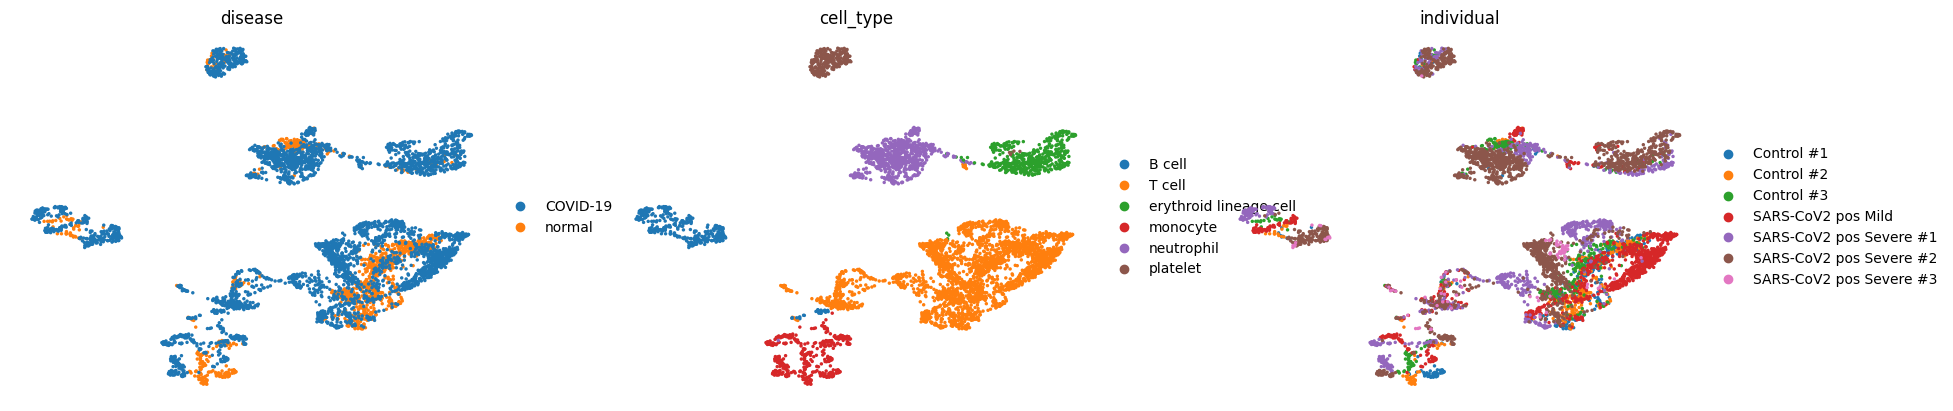

In [100]:
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=2000, batch_key="individual"
)

# Scale the data
sc.pp.scale(adata, max_value=10)

# Generate PCA features
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)

# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata)

# Generate UMAP features
sc.tl.umap(adata)

# Visualize
sc.pl.umap(adata, color=["disease", "cell_type", "individual"], frameon=False)

We can see that we have fairly good mixing of disease conditions (COVID-19/normal) and individuals in our data while the cell types are mostly separated.

### Assess the quality of our pseudo-bulks
When generating pseudobulk profiles, we need to ensure that each aggregated sample has sufficient data for reliable analysis. Samples with too few cells or low total counts may introduce noise and bias into downstream analyses. While the specific thresholds depend on the dataset, requiring at least 10 cells and 1000 total counts per sample helps maintain statistical power while filtering out potentially unreliable measurements.

In [36]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col="individual",  # so we have multiple samples
    groups_col="cell_type",  # defines contrasts
    layer="counts",  # use normalized counts
    mode="sum",  # sum up counts for each group
    min_cells=0,
    min_counts=0,
)

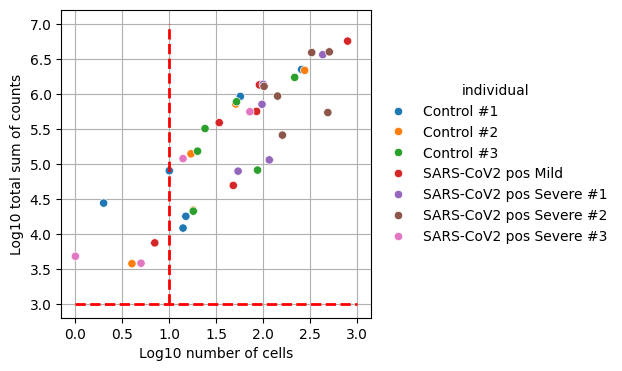

In [40]:
_, ax = plt.subplots(figsize=(4, 4))

ax.hlines(y=3, xmin=0, xmax=3, color="red", linewidth=2, linestyle="--")
ax.vlines(x=1, ymin=3, ymax=7, color="red", linewidth=2, linestyle="--")

dc.plot_psbulk_samples(pdata, groupby="individual", figsize=(12, 4), ax=ax)

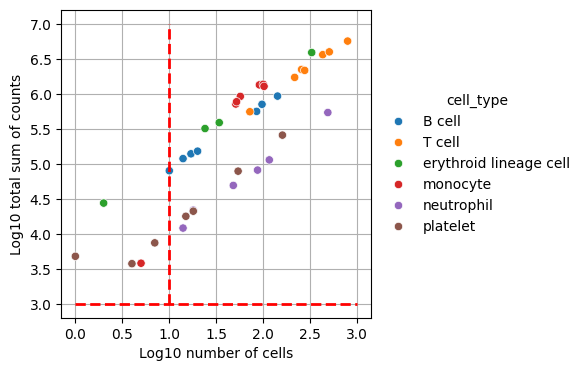

In [41]:
_, ax = plt.subplots(figsize=(4, 4))

ax.hlines(y=3, xmin=0, xmax=3, color="red", linewidth=2, linestyle="--")
ax.vlines(x=1, ymin=3, ymax=7, color="red", linewidth=2, linestyle="--")

dc.plot_psbulk_samples(pdata, groupby="cell_type", figsize=(12, 4), ax=ax)

We'll filter out celltype-individual pseudo-bulks that don't contain at least 10 cells and 1000 total counts.

In [57]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col="individual",  # so we have multiple samples
    groups_col="cell_type",  # defines contrasts
    layer="counts",  # use normalized counts
    mode="sum",  # sum up counts for each group
    min_cells=10,
    min_counts=1000,
)

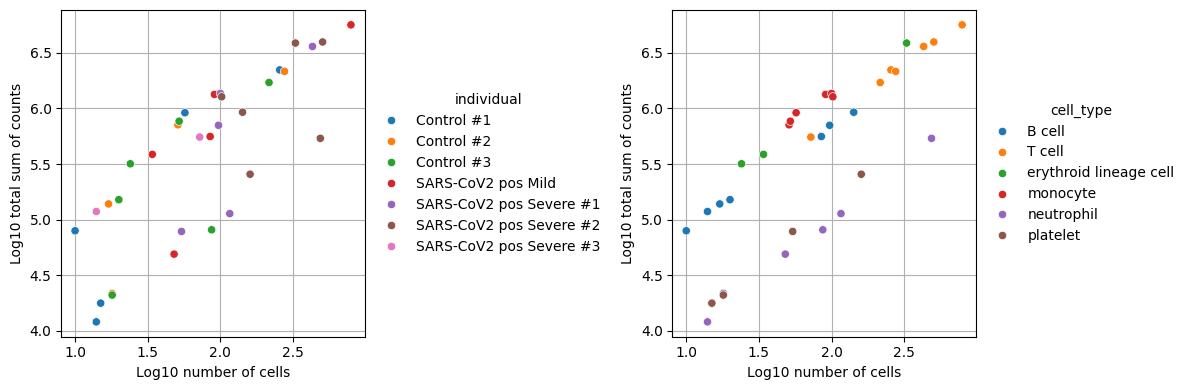

In [58]:
dc.plot_psbulk_samples(pdata, groupby=["individual", "cell_type"], figsize=(12, 4))

We can see that we now end up with 34 observations which represent the filtered `individual_celltype` combinations.

In [102]:
pdata

AnnData object with n_obs × n_vars = 34 × 18463
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [59]:
pdata.to_df().head(8)

gene_symbol                     5S_rRNA  A1BG   A2M  A2MP1  A4GALT  AAAS  \
Control #1_B cell                   0.0   3.0   0.0    0.0     1.0   1.0   
Control #2_B cell                   0.0   7.0   0.0    0.0     0.0   0.0   
Control #3_B cell                   0.0   6.0   0.0    0.0     0.0   0.0   
SARS-CoV2 pos Mild_B cell           0.0  17.0   0.0    0.0     1.0   7.0   
SARS-CoV2 pos Severe #1_B cell      0.0  20.0   0.0    0.0     0.0   2.0   
SARS-CoV2 pos Severe #2_B cell      0.0  28.0   0.0    0.0     0.0   4.0   
SARS-CoV2 pos Severe #3_B cell      0.0   4.0   0.0    0.0     1.0   1.0   
Control #1_T cell                   1.0  70.0  44.0    5.0     5.0  11.0   

gene_symbol                     AACS  AAGAB   AAK1  AAMDC  ...  ZWILCH  ZWINT  \
Control #1_B cell                0.0    0.0    4.0    1.0  ...     0.0    0.0   
Control #2_B cell                2.0    3.0    9.0    2.0  ...     1.0    0.0   
Control #3_B cell                0.0    3.0    8.0    1.0  ...     0.0    0.0   
SARS-CoV2 pos Mild_B cell        4.0    1.0   31.0    3.0  ...     2.0    0.0   
SARS-CoV2 pos Severe #1_B cell  15.0   14.0   25.0    2.0  ...     5.0    0.0   
SARS-CoV2 pos Severe #2_B cell   6.0   11.0   15.0    6.0  ...     1.0    1.0   
SARS-CoV2 pos Severe #3_B cell   2.0    3.0    3.0    0.0  ...     0.0    0.0   
Control #1_T cell               28.0   33.0  704.0   14.0  ...    14.0    4.0   

gene_symbol                     ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B   ZYX  ZZEF1  \
Control #1_B cell                1.0   0.0   3.0     0.0     1.0   1.0   28.0   
Control #2_B cell                3.0   1.0   2.0     1.0     8.0   2.0   60.0   
Control #3_B cell                2.0   0.0   2.0     0.0     2.0   0.0   25.0   
SARS-CoV2 pos Mild_B cell        1.0   3.0   6.0     4.0    34.0   3.0  201.0   
SARS-CoV2 pos Severe #1_B cell   6.0   4.0   9.0     0.0    52.0   8.0  275.0   
SARS-CoV2 pos Severe #2_B cell   5.0   8.0  14.0     1.0    27.0   8.0  211.0   
SARS-CoV2 pos Severe #3_B cell   1.0   1.0   3.0     0.0     8.0   0.0   49.0   
Control #1_T cell               12.0  14.0  38.0     3.0    99.0  58.0  822.0   

gene_symbol                     ZZZ3  
Control #1_B cell                0.0  
Control #2_B cell                1.0  
Control #3_B cell                1.0  
SARS-CoV2 pos Mild_B cell       14.0  
SARS-CoV2 pos Severe #1_B cell  17.0  
SARS-CoV2 pos Severe #2_B cell  25.0  
SARS-CoV2 pos Severe #3_B cell   0.0  
Control #1_T cell               45.0  

[8 rows x 18463 columns]

In [60]:
# let's save the raw counts for later use
pdata.layers["counts"] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, "counts", X_layer_key=None, inplace=True)

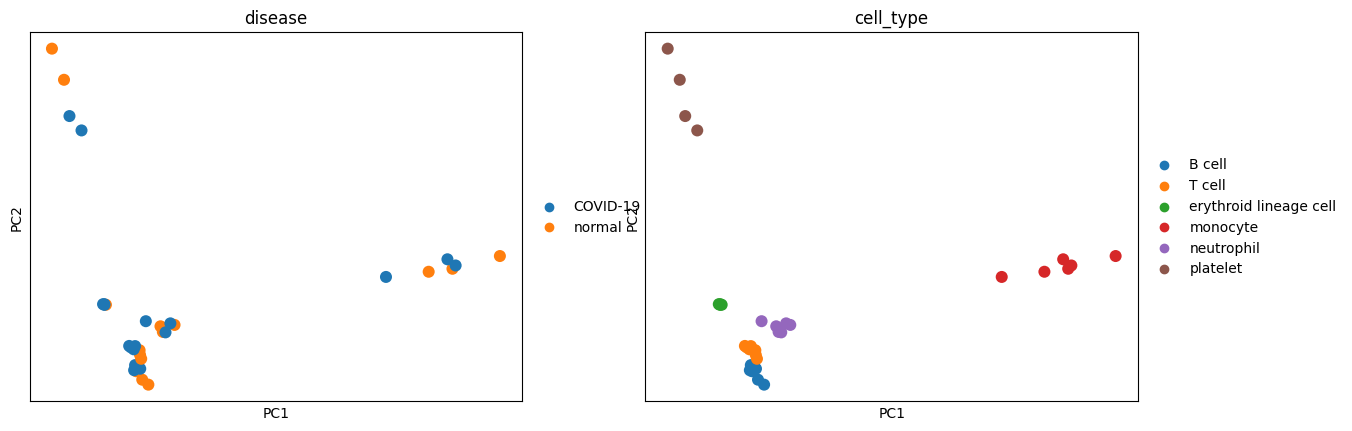

In [52]:
sc.pl.pca(pdata, color=["disease", "cell_type"], size=300)

We see in the PCA that our data seems to cluster well by celltype whereas conditions are mixed. In the plot below we see that PC1 and PC2 explain the majority of the variance which explains why the above plots are separated so well.

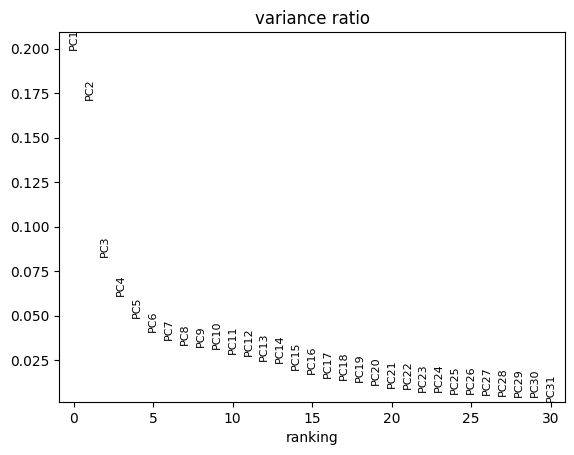

In [61]:
sc.pl.pca_variance_ratio(pdata)

### Denoising the pseudo-bulks
After filtering low-quality samples, we need to ensure that the genes we analyze are reliably expressed. Since different cell types express distinct sets of genes, we perform this filtering separately for each cell type. 

In the next steps, we'll focus on T cells.

In [103]:
tcells = pdata[pdata.obs["cell_type"] == "T cell"].copy()

We expect a bimodal distribution in these genes with one cluster of genes being expressed very little and only by very few samples. We will adjust the `min_count` and `min_total_count` parameters to filter these out.

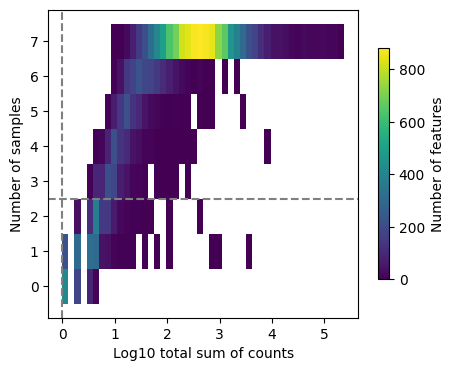

In [105]:
dc.plot_filter_by_expr(tcells, group="disease", min_count=1, min_total_count=1)

Once we've found sufficiently good values, we'll use these to subset the genes in the T cell `AnnData` object. 

In [63]:
genes = dc.filter_by_expr(tcells, group="disease", min_count=10, min_total_count=15)

# Filter by these genes
tcells = tcells[:, genes].copy()
tcells

AnnData object with n_obs × n_vars = 7 × 10393
    obs: 'individual', 'cell_type', 'sex', 'disease', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl_gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

## Differential expression analysis of the pseudo-bulks using `pydeseq2`
In this dataset, a natural contrast to explore is how the gene expression of T cells differes between healthy patients and patienst suffering from COVID-19. To do so, we'll use PyDESeq2, a Python implementation of the popular R packages.

More details can be found in the [PyDESeq2 documentation](https://pydeseq2.readthedocs.io/en/latest/)

In [65]:
inference = DefaultInference(n_cpus=8)

dds = DeseqDataSet(
    adata=tcells,
    design_factors="disease",
    ref_level=["disease", "normal"],
    refit_cooks=True,
    inference=inference,
)

/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_69686/4050698110.py:2: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
/var/folders/qg/qgc908995g3fc8qtss2fsbhhxyxxj4/T/ipykernel_69686/4050698110.py:2: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(


In [67]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.78 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 0.98 seconds.

Fitting LFCs...
... done in 0.71 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [68]:
stat_res = DeseqStats(
    dds,
    contrast=["disease", "COVID-19", "normal"],
    inference=inference,
)

In [69]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: disease COVID-19 vs normal
               baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                             
A1BG          70.478830       -0.203063  0.259224 -0.783351  0.433421   
A2M           36.737832       -1.260093  0.355132 -3.548244  0.000388   
A2MP1         15.628439        0.601803  0.701386  0.858020  0.390881   
AAAS          18.307198        0.254639  0.453519  0.561474  0.574475   
AACS          24.634494        0.259215  0.383214  0.676423  0.498772   
...                 ...             ...       ...       ...       ...   
ZXDC          30.185259       -0.289675  0.373567 -0.775429  0.438086   
ZYG11B       101.897349        0.269827  0.298309  0.904523  0.365718   
ZYX           81.607418        0.303738  0.264875  1.146723  0.251496   
ZZEF1        820.875555        0.027797  0.224519  0.123809  0.901467   
ZZZ3          59.934519       -0.075166  0.303987 -0.247268

... done in 0.45 seconds.



In [70]:
results_df = stat_res.results_df
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                             
A1BG          70.478830       -0.203063  0.259224 -0.783351  0.433421   
A2M           36.737832       -1.260093  0.355132 -3.548244  0.000388   
A2MP1         15.628439        0.601803  0.701386  0.858020  0.390881   
AAAS          18.307198        0.254639  0.453519  0.561474  0.574475   
AACS          24.634494        0.259215  0.383214  0.676423  0.498772   
...                 ...             ...       ...       ...       ...   
ZXDC          30.185259       -0.289675  0.373567 -0.775429  0.438086   
ZYG11B       101.897349        0.269827  0.298309  0.904523  0.365718   
ZYX           81.607418        0.303738  0.264875  1.146723  0.251496   
ZZEF1        820.875555        0.027797  0.224519  0.123809  0.901467   
ZZZ3          59.934519       -0.075166  0.303987 -0.247268  0.804701   

                 padj  
gene_symbol            
A1BG         0.847593  
A2M          0.031502  
A2MP1        0.828224  
AAAS         0.900516  
AACS         0.873693  
...               ...  
ZXDC         0.850122  
ZYG11B       0.813746  
ZYX          0.742821  
ZZEF1        0.983509  
ZZZ3         0.960365  

[10393 rows x 6 columns]

### Visual inspection of differentially expressed genes
Volcano plots visualize differential expression results by plotting statistical significance (-log10 p-value) against effect size (log2 fold change). They help quickly identify genes that show both significant and substantial expression changes between conditions, making them a valuable tool for prioritizing genes for further investigation.

Typically, one adds visual guiding lines at 1.3 for the y-axis (-log10(0.05)) and +/- 1 log2(2) foldchange for the x-axis. 

#### Why the adjusted p-value?
When performing differential expression analysis across thousands of genes, we use adjusted p-values (typically Benjamini-Hochberg correction) to control for multiple testing. This is crucial because testing many genes simultaneously increases the chance of false positives - if we used raw p-values and tested 10,000 genes at p < 0.05, we'd expect about 500 false positives by chance alone. The adjusted p-value (or FDR - False Discovery Rate) helps control this problem by adjusting the significance threshold based on the number of tests performed, giving us more confidence that our findings represent true biological differences rather than statistical artifacts.

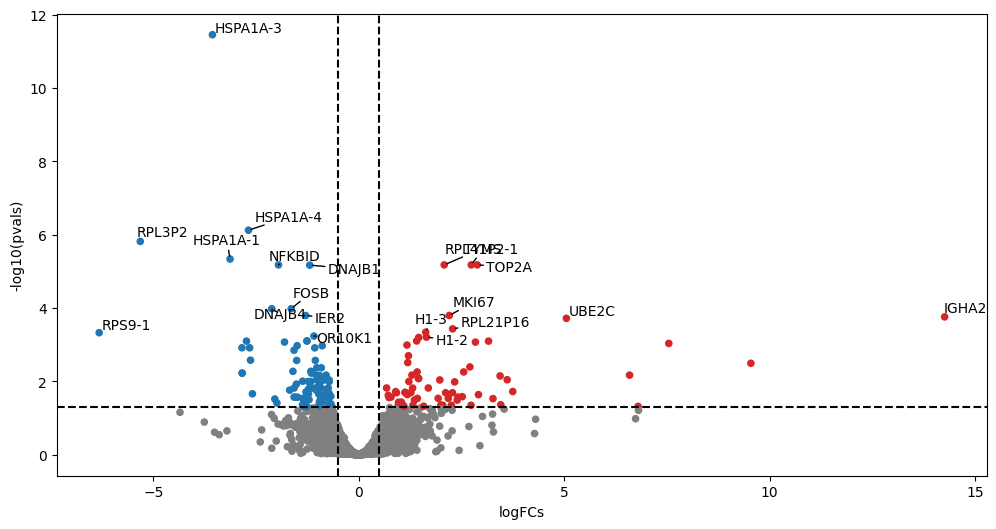

In [75]:
dc.plot_volcano_df(results_df, x="log2FoldChange", y="padj", top=20, figsize=(12, 6))

## Enrichment with Over Representation Analysis (ORA)

Once we have identified differentially expressed genes, we can interpret their biological significance through enrichment analysis. This helps us understand which pathways or biological processes are altered between conditions. We'll use:

1. Over-Representation Analysis (ORA): Tests whether genes in a pathway appear more frequently than expected by chance in our set of differential genes
2. MSigDB gene sets: A comprehensive collection of annotated gene sets for various biological processes
3. Visualization of enrichment results to identify key pathways

This analysis helps translate our gene-level findings into biological insights about pathway regulation and cellular processes.

In [ ]:
msigdb_all = dc.get_resource("MSigDB")
msigdb_all

genesymbol             collection  \
                                            
0             A1BG            immunesigdb   
1             A1BG      tf_targets_legacy   
2             A1BG             positional   
3             A1BG   cell_type_signatures   
4             A1BG  go_cellular_component   
...            ...                    ...   
5522261       ZZZ3  go_biological_process   
5522262       ZZZ3  go_biological_process   
5522263       ZZZ3        tf_targets_gtrf   
5522264       ZZZ3            immunesigdb   
5522265       ZZZ3            immunesigdb   

                                                   geneset  
                                                            
0        GSE25088_CTRL_VS_IL4_AND_ROSIGLITAZONE_STIM_MA...  
1                                          TGTTTGY_HNF3_Q6  
2                                                 chr19q13  
3           GAO_LARGE_INTESTINE_ADULT_CI_MESENCHYMAL_CELLS  
4                    GOCC_EXTERNAL_ENCAPSULATING_STRUCTURE  
...                                                    ...  
5522261                     GOBP_MACROMOLECULE_DEACYLATION  
5522262                                    GOBP_CELL_CYCLE  
5522263                                ZNF507_TARGET_GENES  
5522264      GSE3982_NEUTROPHIL_VS_EFF_MEMORY_CD4_TCELL_DN  
5522265          GSE18893_CTRL_VS_TNF_TREATED_TCONV_24H_UP  

[5522266 rows x 3 columns]

In [89]:
collection = "go_biological_process"

msigdb = msigdb_all[msigdb_all["collection"] == collection]

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(["geneset", "genesymbol"])]

if collection == "hallmark":
    msigdb.loc[:, "geneset"] = [
        name.split("HALLMARK_")[1] for name in msigdb["geneset"]
    ]
elif collection == "go_biological_process":
    msigdb.loc[:, "geneset"] = [name.split("GOBP_")[1] for name in msigdb["geneset"]]

msigdb

genesymbol             collection  \
                                            
73            A1CF  go_biological_process   
78            A1CF  go_biological_process   
84            A1CF  go_biological_process   
87            A1CF  go_biological_process   
88            A1CF  go_biological_process   
...            ...                    ...   
5522215       ZZZ3  go_biological_process   
5522223       ZZZ3  go_biological_process   
5522241       ZZZ3  go_biological_process   
5522261       ZZZ3  go_biological_process   
5522262       ZZZ3  go_biological_process   

                                                   geneset  
                                                            
73                                  MRNA_METABOLIC_PROCESS  
78                                     EMBRYO_IMPLANTATION  
84                         MACROMOLECULE_CATABOLIC_PROCESS  
87                                       MRNA_MODIFICATION  
88                                          RNA_PROCESSING  
...                                                    ...  
5522215                                  PROTEIN_ACYLATION  
5522223                             HISTONE_H3_ACETYLATION  
5522241  REGULATION_OF_MULTICELLULAR_ORGANISMAL_DEVELOP...  
5522261                          MACROMOLECULE_DEACYLATION  
5522262                                         CELL_CYCLE  

[1026039 rows x 3 columns]

In [90]:
top_genes = results_df[results_df["padj"] < 0.05]

enr_pvals = dc.get_ora_df(
    df=top_genes, net=msigdb, source="geneset", target="genesymbol"
)

enr_pvals.head()

Term  Set size  Overlap ratio   p-value  \
0     2_OXOGLUTARATE_METABOLIC_PROCESS        26       0.038462  0.189642   
1  3_UTR_MEDIATED_MRNA_DESTABILIZATION        28       0.035714  0.202653   
2          ACIDIC_AMINO_ACID_TRANSPORT        88       0.022727  0.158084   
3                       ACID_SECRETION        66       0.030303  0.098998   
4         ACTIN_FILAMENT_BASED_PROCESS      1274       0.003925  0.978775   

   FDR p-value  Odds ratio  Combined score                      Features  
0     0.620302    7.044437       11.712207                        L2HGDH  
1     0.628345    6.549434       10.454592                       ZC3H12A  
2     0.597507    3.526646        6.505362                     P2RX7;TNF  
3     0.559738    4.698541       10.866114                     P2RX7;TNF  
4     0.999998    0.516375        0.011078  ACTG1;CORO1A;OPHN1;STMN1;TNF

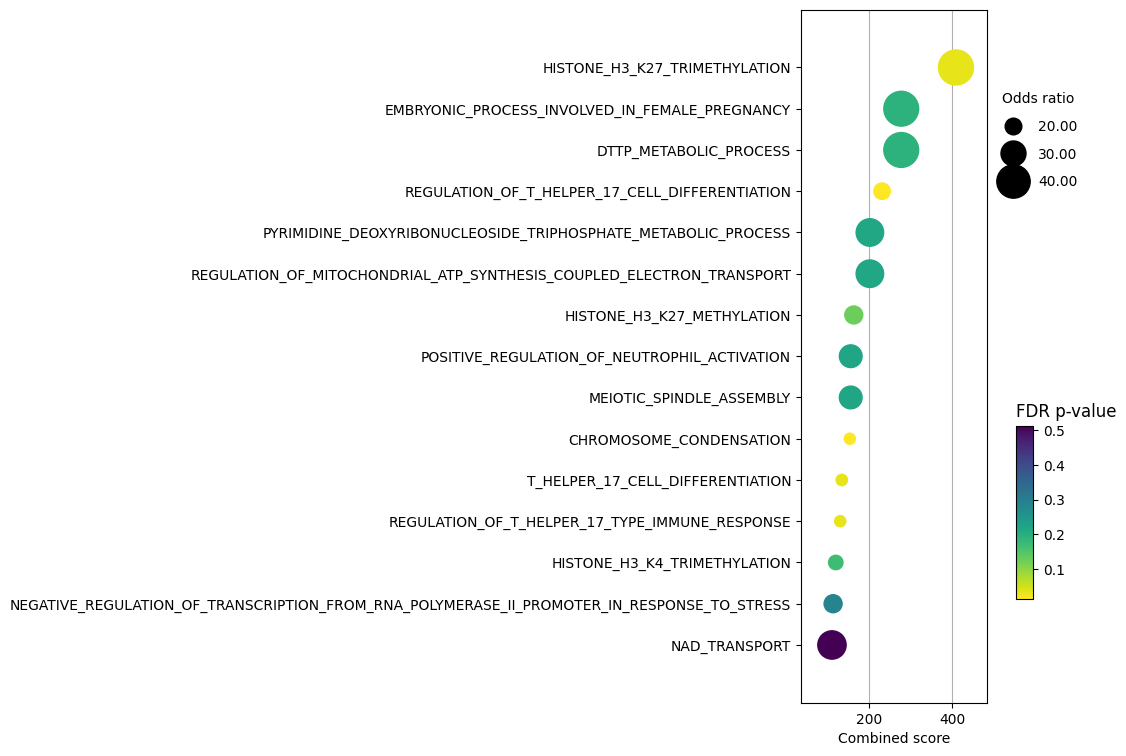

In [95]:
dc.plot_dotplot(
    enr_pvals.sort_values("Combined score", ascending=False).head(15),
    x="Combined score",
    y="Term",
    s="Odds ratio",
    c="FDR p-value",
    scale=0.1,
    figsize=(3, 9),
)